# Amplitude embedding (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# create a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: # image center
        center = (int(w/2), int(h/2))
    if radius is None: # smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask

## 1) Generating an artificial image of the sky (frequency domain)

In [5]:
# image of the sky filled with double precision complex floats (32 bits per real/imaginary parts)
# pixels are set to low complex random values (image background/noise) 
# few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 4
image = np.zeros((n, n), dtype='complex64')
image.real = np.random.randn(n , n)/10
image.imag = np.random.randn(n , n)/100

h, w = image.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = image.copy()
sky_image[mask] = complex(np.random.rand()*10, np.random.rand()*10)
print(sky_image)

[[-0.12934889-6.54635299e-03j -0.01434121-1.23317959e-02j
   0.02688513-1.38072940e-02j -0.1450103 -4.12954902e-03j]
 [-0.02207088+5.07982215e-04j -0.1517309 +3.03302109e-02j
   7.157295  +7.16841364e+00j  0.01022523+1.09932537e-03j]
 [ 0.14437115+1.49679445e-02j  7.157295  +7.16841364e+00j
   7.157295  +7.16841364e+00j  7.157295  +7.16841364e+00j]
 [ 0.03492694+7.54560158e-03j -0.06110955+1.49645307e-03j
   7.157295  +7.16841364e+00j  0.01925043+6.49114884e-03j]]


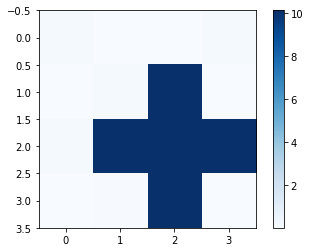

In [6]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [7]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 35.498524 +35.86769j   -21.454859 -21.363312j    7.5547748 +7.1481256j
  -21.486927 -21.586605j ]
 [-21.861668 -21.40038j     6.923046  +7.0528097j   7.0393324 +7.1069045j
    6.7762585 +7.3825994j]
 [  7.21036   +7.099096j    7.1001377 +6.8096037j -21.466848 -21.462801j
    7.1650147 +7.555574j ]
 [-21.894476 -21.713669j    6.773929  +7.007265j    7.1002913 +7.192202j
    6.953526  +7.2001524j]]


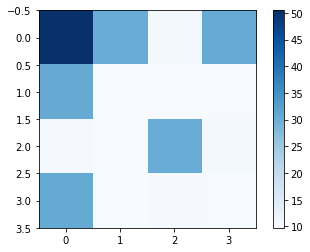

In [8]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [9]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 7.2672445e-15
Imaginaries MSE: 3.00999e-15


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [10]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

#normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(int(math.log2(n))) # set the number of qubits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires) # normalize = True
    return qml.state() #qml.expval(qml.PauliZ(wires=wires))

readout = amp_encoding(normalized_data).astype('complex64')
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

[[ 35.49852  +35.86769j   -21.454859 -21.36331j     7.5547748 +7.1481256j
  -21.486925 -21.586605j ]
 [-21.861668 -21.400377j    6.923046  +7.0528097j   7.0393324 +7.106904j
    6.7762585 +7.382599j ]
 [  7.21036   +7.099096j    7.1001377 +6.809603j  -21.466848 -21.462801j
    7.1650143 +7.5555735j]
 [-21.894474 -21.713669j    6.773929  +7.0072646j   7.100291  +7.1922016j
    6.953526  +7.2001524j]]


## 4) Applying 2D IFT (fidelity test)

In [11]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 8.4042636e-14
Imaginaries MSE: 4.5737963e-14
